In [2]:
from platform import python_version

print(python_version())

3.7.4


In [4]:
import sys
# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('./secrets.py')

import logging
import math
import os

from influxdb import DataFrameClient
import numpy as np
import matplotlib.mlab as mlab
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import tqdm
%matplotlib inline

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Need to ssh tunnel for this to work
# ssh -L 8086:localhost:8086 aq.byu.edu -N
influx = DataFrameClient(
    host=HOST,
    port=PORT,
    username=USERNAME,
    password=PASSWORD,
    database=DATABASE,
)


def large_query(influx, measurement, query, total=None, limit=100_000):
    if total is not None:
        total = math.ceil(total / limit)

    with tqdm(total=total) as pbar:
        offset = 0
        while True:
            new_query = query + " LIMIT {} OFFSET {}".format(limit, offset)
            data = influx.query(new_query)
            data = data[measurement]

            received = len(data)
            pbar.update(1)

            yield data

            offset += limit
            if received != limit:
                break


def load_data(filename):
    if os.path.exists(filename):
        LOGGER.info("Loading cached data...")
        return pd.read_hdf(filename)

    LOGGER.info("Downloading data...")
    result = influx.query(
        "SELECT COUNT(sequence) FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'"
    )
    count = result["air_quality_sensor"].values[0][0]

    queries = large_query(
        influx,
        "air_quality_sensor",
        "SELECT * FROM air_quality_sensor WHERE time > '2019-10-01' AND time <= '2020-04-30'",
        count,
    )

    all_data = pd.concat(list(queries), sort=False)
    all_data.to_hdf(filename, "data")
    return all_data


data = load_data("aq_data.h5")
gold_data = load_data("aq_data.h5")

LOGGER.info("Done loading data...")



INFO:__main__:Loading cached data...
INFO:__main__:Loading cached data...
INFO:__main__:Done loading data...


2019-10-01 00:00:05+00:00
2019-10-01 08:00:05+08:00
All Sensors names: ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object')
All Hybrid Modified Gers list size: 3384669
whiskers:  [0.0, 245.01649484536082]
caps:  [0.0, 245.01649484536082]
boxes:  [13.268041237113401]
medians:  [37.15051546391752]
means:  [91.6865982926842]
fliers:  []


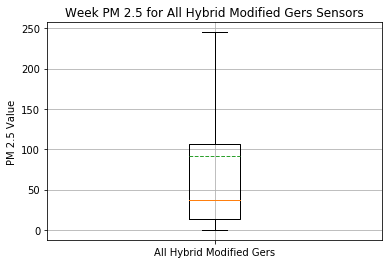

In [5]:
# all_hybrid_modified_gers - This is the working boxplot for all_hybrid_modified_gers only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['All Hybrid Modified Gers']
plt.xlabel('')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for All Hybrid Modified Gers Sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']

# Clean up data this way:
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
data['pm2_5'] = data['pm2_5'] / (1 + ((0.4/1.65)/(-1+(1/(35/100)))))
# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

all_hybrid_modified_gers = [data['pm2_5'].dropna()]
print('{} list size: {}'.format(labels[0], len(data['pm2_5'].dropna())))
results = plt.boxplot(all_hybrid_modified_gers, showfliers=False, labels=labels, showmeans=True, meanline=True)

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-10-01 08:00:05+08:00
2019-10-01 08:00:05+08:00
All Sensors names: ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object')
Mon list size: 460563
Tue list size: 476602
Wed list size: 489212
Thu list size: 487337
Fri list size: 501691
Sat list size: 489751
Sun list size: 479513
total for all days: 3384669

whiskers:  [0.0, 200.29544478690613, 0.0, 222.20275906047402, 0.0, 209.68429376129237, 0.0, 208.11948559889467, 0.0, 232.37401211605908, 0.0, 204.98986927409925, 0.0, 232.37401211605908]
caps:  [0.0, 200.29544478690613, 0.0, 222.20275906047402, 0.0, 209.68429376129237, 0.0, 208.11948559889467, 0.0, 232.37401211605908, 0.0, 204.98986927409925, 0.0, 232.37401211605908]
boxes:  [10.95365713678393, 10.95365713678393, 10.1

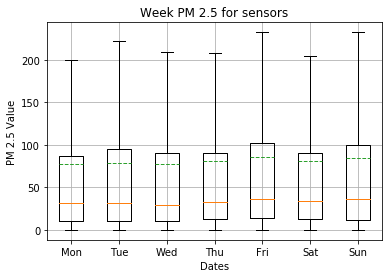

In [6]:
# Day - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html

from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.xlabel('Dates')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days = ['05', '06', '07', '08', '09', '10', '11']

# Clean up data this way:
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
data['pm2_5'] = data['pm2_5'] / (1 + ((0.4/1.65)/(-1+(1/(35/100)))))
# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])

monday = data[(data.index.day_name() == 'Monday')]['pm2_5'].dropna()
tuesday = data[data.index.day_name() == 'Tuesday']['pm2_5'].dropna()
wednesday = data[data.index.day_name() == 'Wednesday']['pm2_5'].dropna()
thursday = data[data.index.day_name() == 'Thursday']['pm2_5'].dropna()
friday = data[data.index.day_name() == 'Friday']['pm2_5'].dropna()
saturday = data[data.index.day_name() == 'Saturday']['pm2_5'].dropna()
sunday = data[data.index.day_name() == 'Sunday']['pm2_5'].dropna()
all_days = [monday, tuesday, wednesday, thursday, friday, saturday, sunday]

results = plt.boxplot(all_days, showfliers=False, labels=labels, showmeans=True, meanline=True)

i = 0
cumulative = 0
for day in all_days:
    print('{} list size: {}'.format(labels[i], len(day)))
    cumulative += len(day)
    i+= 1
print('total for all days: {}'.format(cumulative))
print()

# print(results)
print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
print('caps: ', [item.get_ydata()[1] for item in results['caps']])
print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
print('medians: ', [item.get_ydata()[1] for item in results['medians']])
print('means: ', [item.get_ydata()[1] for item in results['means']])
print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])

data = gold_data

2019-10-01 08:00:05+08:00
2019-10-01 08:00:05+08:00
All Sensors names: ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
<class 'pandas.core.indexes.base.Index'>
Index(['Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday', 'Saturday',
       'Saturday', 'Saturday', 'Saturday', 'Saturday'],
      dtype='object')
Monday - AL list size: 32111
Monday - AR list size: 20509
Monday - AZ list size: 34237
Monday - CA list size: 23485
Monday - CT list size: 11207
Monday - DE list size: 36164
Monday - IA list size: 10217
Monday - ID list size: 28698
Monday - IL list size: 23413
Monday - KS list size: 22342
Monday - LA list size: 17459
Monday - MA list size: 32147
Monday - MD list size: 26362
Monday - ME list size: 36456
Monday - MI list size: 7079
Monday - MN list size: 22754
Monday - MS list size: 21375
Monday - MT list size: 20523
Monday - NC list size: 28890
Monday - NH list size: 24476
Monday - NM list size: 25

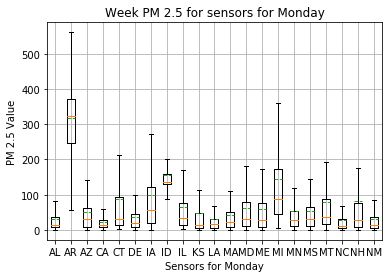

Tuesday - AL list size: 33180
Tuesday - AR list size: 20300
Tuesday - AZ list size: 34953
Tuesday - CA list size: 24461
Tuesday - CT list size: 12498
Tuesday - DE list size: 37442
Tuesday - IA list size: 7025
Tuesday - ID list size: 29749
Tuesday - IL list size: 23126
Tuesday - KS list size: 23777
Tuesday - LA list size: 15996
Tuesday - MA list size: 33193
Tuesday - MD list size: 28439
Tuesday - ME list size: 36436
Tuesday - MI list size: 10153
Tuesday - MN list size: 23472
Tuesday - MS list size: 21074
Tuesday - MT list size: 23170
Tuesday - NC list size: 30490
Tuesday - NH list size: 25670
Tuesday - NM list size: 26739
Tuesday total: 521343

whiskers:  [0.0, 102.42556685253096, 7.612711049850274, 568.1850701751887, 0.0, 149.48596243342357, 0.0, 62.285817680593155, 1.384129281790959, 141.87325138357332, 0.0, 96.88904972536713, 4.1523878453728775, 253.98772320864097, 62.97788232148863, 247.75914144058166, 2.768258563581918, 249.83533536326811, 0.0, 151.56215635611002, 0.0, 60.209623757

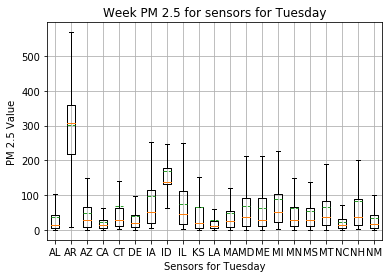

Wednesday - AL list size: 33431
Wednesday - AR list size: 22608
Wednesday - AZ list size: 35007
Wednesday - CA list size: 24474
Wednesday - CT list size: 13071
Wednesday - DE list size: 37967
Wednesday - IA list size: 8376
Wednesday - ID list size: 31700
Wednesday - IL list size: 23521
Wednesday - KS list size: 25091
Wednesday - LA list size: 14889
Wednesday - MA list size: 34560
Wednesday - MD list size: 30405
Wednesday - ME list size: 36562
Wednesday - MI list size: 9615
Wednesday - MN list size: 24116
Wednesday - MS list size: 24142
Wednesday - MT list size: 25984
Wednesday - NC list size: 31908
Wednesday - NH list size: 26096
Wednesday - NM list size: 25578
Wednesday total: 539101

whiskers:  [0.0, 76.81917513939823, 18.685745304177946, 574.4136519432479, 0.0, 128.7240232065592, 0.0, 70.59059337133891, 0.0, 136.33673425640944, 0.0, 101.04143757074002, 0.0, 204.85113370506193, 117.6509889522315, 175.78441878745178, 2.768258563581918, 233.91784862267204, 0.0, 83.04775690745754, 0.0, 

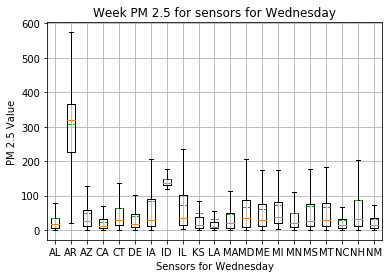

Thursday - AL list size: 34390
Thursday - AR list size: 25263
Thursday - AZ list size: 35500
Thursday - CA list size: 24479
Thursday - CT list size: 9821
Thursday - DE list size: 38567
Thursday - IA list size: 9130
Thursday - ID list size: 29660
Thursday - IL list size: 24406
Thursday - KS list size: 22191
Thursday - LA list size: 16096
Thursday - MA list size: 34556
Thursday - MD list size: 30621
Thursday - ME list size: 36137
Thursday - MI list size: 8056
Thursday - MN list size: 21002
Thursday - MS list size: 21830
Thursday - MT list size: 23936
Thursday - NC list size: 32336
Thursday - NH list size: 26524
Thursday - NM list size: 26512
Thursday total: 531013

whiskers:  [0.6920646408954795, 71.28265801223439, 22.838133149550824, 600.7121082972762, 0.0, 129.41608784745466, 0.0, 77.5112397802937, 1.384129281790959, 199.3146165778981, 0.0, 98.27317900715809, 0.6920646408954795, 184.78125911909302, 96.19698508447166, 190.31777624625687, 0.0, 209.0035215504348, 0.0, 112.80653646596316, 

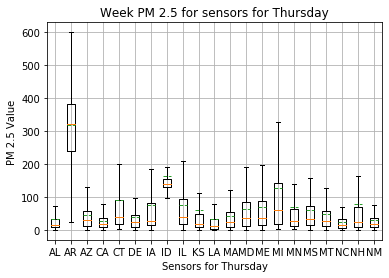

Friday - AL list size: 35983
Friday - AR list size: 25908
Friday - AZ list size: 37010
Friday - CA list size: 24470
Friday - CT list size: 11229
Friday - DE list size: 38756
Friday - IA list size: 9302
Friday - ID list size: 30250
Friday - IL list size: 24583
Friday - KS list size: 24166
Friday - LA list size: 17416
Friday - MA list size: 34043
Friday - MD list size: 32805
Friday - ME list size: 35996
Friday - MI list size: 7647
Friday - MN list size: 22401
Friday - MS list size: 22953
Friday - MT list size: 23599
Friday - NC list size: 32772
Friday - NH list size: 25324
Friday - NM list size: 24331
Friday total: 540944

whiskers:  [0.6920646408954795, 98.27317900715809, 143.94944530625975, 559.1882298435474, 0.6920646408954795, 149.48596243342357, 0.0, 77.5112397802937, 0.6920646408954795, 140.48912210178233, 0.6920646408954795, 103.11763149342646, 2.0761939226864388, 258.8321756949093, 120.41924751581342, 189.62571160536137, 2.0761939226864388, 239.45436574983592, 0.6920646408954795,

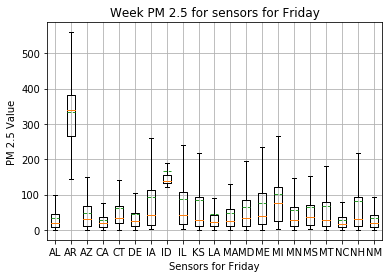

Saturday - AL list size: 35698
Saturday - AR list size: 23302
Saturday - AZ list size: 37364
Saturday - CA list size: 24477
Saturday - CT list size: 11109
Saturday - DE list size: 38682
Saturday - IA list size: 10176
Saturday - ID list size: 30549
Saturday - IL list size: 24888
Saturday - KS list size: 23459
Saturday - LA list size: 15866
Saturday - MA list size: 33265
Saturday - MD list size: 32467
Saturday - ME list size: 35995
Saturday - MI list size: 7636
Saturday - MN list size: 23136
Saturday - MS list size: 23335
Saturday - MT list size: 23638
Saturday - NC list size: 33126
Saturday - NH list size: 23828
Saturday - NM list size: 23693
Saturday total: 535689

whiskers:  [0.0, 85.12395083014398, 125.26370000208179, 548.1151955892198, 0.6920646408954795, 126.64782928387274, 0.0, 69.20646408954795, 0.0, 150.87009171521453, 0.6920646408954795, 95.50492044357617, 0.6920646408954795, 186.16538840088398, 103.11763149342646, 182.0130005555111, 2.0761939226864388, 197.93048729610715, 0.69

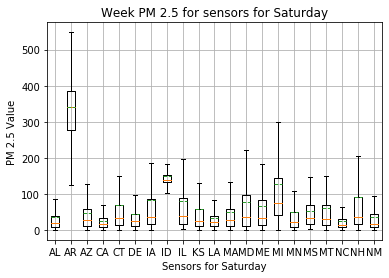

Sunday - AL list size: 33300
Sunday - AR list size: 21859
Sunday - AZ list size: 37285
Sunday - CA list size: 24473
Sunday - CT list size: 11633
Sunday - DE list size: 38806
Sunday - IA list size: 10317
Sunday - ID list size: 28834
Sunday - IL list size: 24769
Sunday - KS list size: 21941
Sunday - LA list size: 16086
Sunday - MA list size: 33116
Sunday - MD list size: 28722
Sunday - ME list size: 36009
Sunday - MI list size: 7787
Sunday - MN list size: 24893
Sunday - MS list size: 24479
Sunday - MT list size: 20502
Sunday - NC list size: 32762
Sunday - NH list size: 23311
Sunday - NM list size: 26235
Sunday total: 527119

whiskers:  [0.0, 101.04143757074002, 39.447684531042334, 593.0993972474259, 0.0, 151.56215635611002, 0.0, 74.74298121671178, 0.6920646408954795, 164.71138453312412, 0.0, 97.58111436626261, 0.6920646408954795, 296.8957309441607, 83.739821548353, 211.07971547312124, 0.6920646408954795, 251.91152928595451, 0.0, 136.33673425640944, 0.6920646408954795, 93.42872652088974, 0

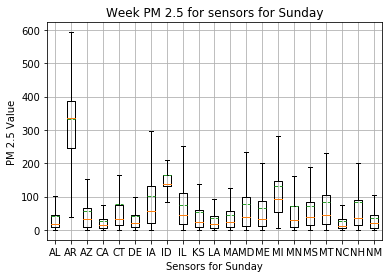

In [7]:
# Day each sensors - This is the working boxplot for hybrid only Mongolia deployed sensors
# https://stackoverflow.com/questions/22800079/converting-time-zone-pandas-dataframe
# https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.DataFrame.between_time.html
import numpy as np
from IPython.core.debugger import set_trace 
# https://matplotlib.org/3.1.3/gallery/statistics/boxplot_color.html 
data = gold_data
print(data.index[1])
# data = data.tz_convert(None)
# data.index = data.index.tz_localize('GMT')
data.index = data.index.tz_convert('Asia/Ulaanbaatar')
print(data.index[1])

labels = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'IA', 'KS', 'KY', 'LA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH']
plt.xlabel('Sensors')
plt.ylabel('PM 2.5 Value')
plt.title('Week PM 2.5 for sensors')
plt.grid(True)
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Clean up data this way:
data.loc[data['pm2_5'] > 1000, 'pm2_5'] = 1000
data.loc[data['pm2_5'] < 0, 'pm2_5'] = 0
# https://www.geeksforgeeks.org/create-a-new-column-in-pandas-dataframe-based-on-the-existing-columns/
data['pm2_5'] = data['pm2_5'] / (1 + ((0.4/1.65)/(-1+(1/(35/100)))))
# data['pm2_5'] = np.where(data['pm2_5'] >= 5000, 5000, data['pm2_5'])

data = data[data.location_name == 'Mongolia']
hybrid_modified_gers = ['AL', 'AR', 'AZ', 'CA', 'CT', 'DE', 'IA', 'ID', 'IL', 'KS', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MS', 'MT', 'NC', 'NH', 'NM']
data = data[(data.name == hybrid_modified_gers[0]) | (data.name == hybrid_modified_gers[1]) | (data.name == hybrid_modified_gers[2]) | (data.name == hybrid_modified_gers[3]) | (data.name == hybrid_modified_gers[4]) | (data.name == hybrid_modified_gers[5]) | (data.name == hybrid_modified_gers[6]) | (data.name == hybrid_modified_gers[7]) | (data.name == hybrid_modified_gers[8]) | (data.name == hybrid_modified_gers[9]) | (data.name == hybrid_modified_gers[10]) | (data.name == hybrid_modified_gers[11]) | (data.name == hybrid_modified_gers[12]) | (data.name == hybrid_modified_gers[13]) | (data.name == hybrid_modified_gers[14]) | (data.name == hybrid_modified_gers[15]) | (data.name == hybrid_modified_gers[16]) | (data.name == hybrid_modified_gers[17]) | (data.name == hybrid_modified_gers[18]) | (data.name == hybrid_modified_gers[19]) | (data.name == hybrid_modified_gers[20])]

all_sensors_names = []
for name, sensor_data in data.groupby("name"):
    all_sensors_names.append(name)
print("All Sensors names:", all_sensors_names)

day_names = data.index.day_name()
print(type(day_names))
print(day_names[:10])


# for name, sensor_data in data.groupby("name"):
for day in days_of_week:
    plt.xlabel('Sensors for {0}'.format(day))
    plt.ylabel('PM 2.5 Value')
    plt.title('Week PM 2.5 for sensors for {0}'.format(day))
    plt.grid(True)
    sensors_data = list()
    sensors_name = list()
    temp = data[data.index.day_name() == day]
    # temp = temp.groupby("name")
    cumulative = 0
    for name, sensor_data in temp.groupby("name"):
        sensors_name.append(name)
        sensors_data.append(temp.groupby("name").get_group(name)["pm2_5"].dropna().to_numpy().tolist())
        cumulative += len(sensor_data)
        print('{} - {} list size: {}'.format(day, name,  len(sensor_data)))
    print ('{} total: {}'.format(day, cumulative))    
    print()
    results = plt.boxplot(sensors_data, showfliers=False, labels=sensors_name, showmeans=True, meanline=True)
    print('whiskers: ', [item.get_ydata()[1] for item in results['whiskers']])
    print('caps: ', [item.get_ydata()[1] for item in results['caps']])
    print('boxes: ', [item.get_ydata()[1] for item in results['boxes']])
    print('medians: ', [item.get_ydata()[1] for item in results['medians']])
    print('means: ', [item.get_ydata()[1] for item in results['means']])
    print('fliers: ', [item.get_ydata()[1] for item in results['fliers']])
    plt.show()
    
data = gold_data